**Topic and Sentiment Analysis of Amazon Music Reviews**

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import json
import nltk
import copy
import csv
import time
import re
import spacy
from wordcloud import WordCloud
from gensim.models import CoherenceModel, Phrases
from gensim.parsing.preprocessing import remove_stopwords
import gensim.corpora as corpora
import gensim
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import pyLDAvis.gensim
import pyLDAvis
warnings.filterwarnings('ignore')

# Introduction

This notebook contains a two-part analysis of a dataset of Amazon CD and Vinyl reviews: a topic analysis and sentiment analysis. Roughly 100,000 reviews are randomly sampled from the original dataset, which contains about 1.1 million records. The reviews were then classified as positive or negative based on the value of the rating (1-2 stars is rated as "negative" and 4-5 stars is rated as "positive." Neutral 3-star reviews were excluded). After various pre-processing and vectorization steps are applied to the text of the reviews, the topic analysis is performed using Latent Dirichlet Allocation. The sentiment analysis is performed using a variety of classification methods.

#### Read in and preview data

In [2]:
path = os.getcwd() + '/data/'

In [3]:
data = []
for line in open(path + 'reviews_CDs_and_Vinyl_5.json'):
    line = json.loads(line)
    overall = line['overall']
    ### some reviews are missing review text and summaries
    try: reviewText = line['reviewText']
    except KeyError: reviewText = None
    try: summary = line['summary']
    except KeyError: summary = None
    data.append([overall, reviewerName, reviewText, summary])

df = pd.DataFrame(data, columns=['overall', 'reviewText', 'summary',])

## Overview of dataset
This dataset contains a sample of Amazon reviews of CD and vinyl reviews from 1996-2014. It was obtained from the website of University of California San Diego computer science professor Julian McAuley:
http://jmcauley.ucsd.edu/data/amazon/.

The dataset contains roughly 1.1 million records and includes the following columns, though many records are missing certain fields:
- reviewerID - Unique ID of the reviewer
- asin - ID of the product
- reviewerName
- vote - flag for helpful votes of the review
- dictionary of product metadata
- reviewText - text of the review
- overall - product rating
- summary - summary of review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)
- image - images that users post after they have received the product
- verified - indicates whether Amazon has verified the product was purchased on Amazon.com

Many of these are not relevant for this analysis, so when reading in the file, I have narrowed the data to the following columns:
- reviewText
- overall
- summary

Remove records that are missing either reviewer text or summaries.

In [5]:
df = df[df.reviewText.notnull() & df['summary'].notnull()]

## Sentiment labeling

Reviews will be classified as positive or negative based on their rating:
- Negative: 1 or 2 stars
- Positive: 4 or 5 stars
- Neutral ratings with a score of 3 will be removed

In [31]:
### Preview distribution of ratings
df.overall.value_counts()

5.0    656676
4.0    246326
3.0    101824
2.0     46571
1.0     46195
Name: overall, dtype: int64

In [32]:
### drop neutral (3-star) reviews. 
df = df[df.overall!=3]

In [33]:
### set target sentiment variable to be 1 for negative/0 for positive
df['sentiment'] = np.where(df.overall <= 2, 1, 0)

The imbalance between positive and negative reviews (less than 10% are negative) will be important to consider during sentiment analysis.

In [34]:
print('Total reviews by sentiment:')
print('Positive total: {} reviews| {}% of total'.format(len(df) - df.sentiment.sum(),
                        np.round(100* (1- df.sentiment.mean()),1)))
print('Negative total: {}reviews| {}% of total'.format(df.sentiment.sum(),
                        np.round(100* df.sentiment.mean(),1)))

Total reviews by sentiment:
Positive total: 903002| 90.7%
Negative total: 92766| 9.3%


To make the analysis more more manageable (particularly for performing LDA), the dataset will be reduced to 100,000 reviews through random sampling.

In [35]:
df = df.sample(100000, random_state=42)

### Split data into test and training sets (80/20)

In [36]:
y = df.sentiment
X = df.drop('sentiment', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=42)
y_train = y_train.values
y_test = y_test.values

# Data preprocessing

### Normalizing the corpus
This includes the following steps:

- Tokenizing words.
- Removing non-alphanumeric characters (except for exclamation marks and question marks, which might be useful for sentiment analysis).
- Lemmatization.
- Handling contractions.
- Removing extraneous whitespace.
- Removing stopwords (though retaining some that might be useful for sentiment analysis, such as words used for negation).

In [31]:
### stopwords on nltk site included more than what was in actual
### package, so I downloaded these from here:
#***************************************************************
# *     Title: NLTK Corpora
# *     Availability: https://www.nltk.org/nltk_data/
#***************************************************************
stopwords = [i for i in open(path + 'nltk_stop_words.txt')\
             .read().split('\n')][:-1]

In [38]:
### remove some stopwords that might be useful for sentiment analysis.
omit = ['no', 'not', 'but', 'against', 'above', 'below', 'up', 'down',
     'over', 'under', 'further', 'more', 'most', 'only', 'very']
for word in stopwords:
    stopwords.remove(word)

Load a contraction mapping dictionary.

In [39]:
### Contraction mapping dictionary obtained from:
#***************************************************************
# *     Author: Sarkar, D
# *     Date: 2011
# *     Title: contractions.py (GitHub repository)
# *     Availability: https://github.com/dipanjanS/practical-mac
# *     hine-learning-with-python/blob/master/notebooks/Ch07_Ana
# *     lyzing_Movie_Reviews_Sentiment/contractions.py
#***************************************************************
f = open(path + 'contraction_map.json')
contractions = json.load(f)

In [40]:
### load spacy model package to use for lemmatization
nlp = spacy.load('en_core_web_sm', parse=True, tag=True,
                 entity=True)

In [41]:
### extract vector of reviews
train_reviews_raw = X_train.reviewText.values
test_reviews_raw = X_test.reviewText.values

In [42]:
def normalize(reviews):
    
    '''Receives array of original reviews and does the following:
    - removing most punctuation
    - removing extraneous whitespace
    - removing non-alphanumeric characters
    - performs lemmatization
    - removes stopwords
    - tokenizes sentences into words
    This then returns the normalized documents'''
    
    start = time.time()
    iter = 1
    updated_reviews = []
    for review in reviews:
        # lowercase and apply contraction map
        for key in contractions.keys():
            review = re.sub(key, contractions[key], review).lower()
        
        ### Create whitespace around question marks and exclamation
        ### marks so that they can be split into separate terms
        review = re.sub(r'(\?|\!)', r' \1 ', review)
        ### replace multiple spaces
        review = re.sub(r' +', ' ', review)
        ### remove all characters that aren't alphanumeric, single
        ### spaces, ? or !.
        review = re.sub('[^\sA-Za-z0-9\?\!]+', '', review)
        ### split, apply stopwords and lemmatize
        review = nlp(review)
        review = [word.lemma_.strip() if word.lemma_!='-PRON-'\
                 and word.lemma not in stopwords else word.text.strip()\
                 for word in review]
        ### this is slow, so track the progress
        if iter %5000==0:
            print('iter:', iter)
            print('time so far:', time.time() - start)
        iter +=1

        updated_reviews.append(review)
    return updated_reviews

In [29]:
%%time
train_reviews_norm = normalize(train_reviews_raw)

In [30]:
%%time
test_reviews_norm = normalize(test_reviews_raw)

Write files locally so that preprocessing does not need to be done each time the notebook is opened.

In [47]:

with open(path +'train_reviews_normalized.txt', 'w') as tr_f:
    writer = csv.writer(tr_f)
    writer.writerows(train_reviews_norm)
    
with open(path + 'test_reviews_normalized.txt', 'w') as tr_f:
    writer = csv.writer(tr_f)
    writer.writerows(test_reviews_norm)
    
### write y_train and y_test locally as well
pd.DataFrame(y_train, columns=['sentiment']).to_csv(path + 'y_train.csv',
                                                    index=False)
pd.DataFrame(y_test, columns=['sentiment']).to_csv(path + 'y_test.csv',
                                                   index=False)

Read in local files if not running the notebook for the first time.

In [3]:
train_reviews_norm = []
test_reviews_norm = []
with open(path + 'train_reviews_normalized.txt', 'r') as tr_f:
    reader = csv.reader(tr_f)
    for row in reader:
        train_reviews_norm.append(' '.join([w for w in row]).strip())
        
with open(path + 'test_reviews_normalized.txt', 'r') as test_f:
    reader = csv.reader(test_f)
    for row in reader:
        test_reviews_norm.append(' '.join([w for w in row]).strip())
        
y_train = pd.read_csv(path + 'y_train.csv')['sentiment'].values
y_test = pd.read_csv(path + 'y_test.csv')['sentiment'].values

# Topic Analysis using LDA

To identify an ideal set of topics, a range of parameter settings were tested when building the bag-of-words features set used in the LDA model. Hyperparameter tuning was also conducted when building the LDA model itself, with topic coherence being used as the scoring metric. Coherence evaluates topics by "measuring the degree of semantic similarity between high scoring words in the topic" (Kapadia, 2019).

### Develop baseline model

Before parameter tuning, baseline coherence scores were established for both positive and negative training sets. The baseline models included five topics and were developed using gensim's ldamulticore class applied to a bag-of-words feature set.

In [4]:
## To separate normalized training corpus into positive and
## negative reviews, the indexes of the y-vector, which has
## the labels for sentiment classes, are needed.
train_pos_idx = np.where(y_train==0)[0]
train_neg_idx = np.where(y_train==1)[0]

### remove the exclamation and question marks, which were left
### in only for sentiment analysis
train_reviews_norm = [re.sub(r' \?| \!', '', x) for x in train_reviews_norm]

train_pos_reviews = [train_reviews_norm[i] for i in train_pos_idx]
train_neg_reviews = [train_reviews_norm[i] for i in train_neg_idx]

### Vectorization (using bag-of-words model)

In [27]:
# %%time
## Build dictionary of words
train_pos_reviews = [i.split() for i in train_pos_reviews]
train_neg_reviews = [i.split() for i in train_neg_reviews]
train_pos_id2word = corpora.Dictionary(train_pos_reviews)
train_neg_id2word = corpora.Dictionary(train_neg_reviews)

In [28]:
### Filter the dictionary to exclude words that are used very
### rarely or very frequently.
train_pos_filtered = copy.deepcopy(train_pos_id2word)
train_pos_filtered.filter_extremes(no_below=.002 *\
                    len(train_pos_id2word), no_above=0.2)

train_neg_filtered = copy.deepcopy(train_neg_id2word)
train_neg_filtered.filter_extremes(no_below=.002 *\
                    len(train_neg_id2word), no_above=0.2)

In [29]:
## create corpus
train_pos_corpus = [train_pos_filtered.doc2bow(text)\
                    for text in train_pos_reviews]
train_neg_corpus = [train_neg_filtered.doc2bow(text)\
                    for text in train_neg_reviews]

### Baseline coherence score for positive review topics

In [30]:
# %%time
baseline_pos_lda = gensim.models.LdaMulticore(corpus=train_pos_corpus,
                                     id2word=train_pos_filtered,
                                     num_topics=5,
                                     random_state=42,
                                     chunksize=100,
                                     passes=10)

baseline_pos_coherence = CoherenceModel(model=baseline_pos_lda,
                               texts=train_pos_reviews,
                               dictionary=train_pos_filtered,
                               coherence= 'c_v')

print('Baseline coherence for positive review topics:',
      np.round(baseline_pos_coherence.get_coherence(),3))

Baseline coherence for positive review topics: 0.34


### Baseline coherence score for negative review topics

In [31]:
# %%time
baseline_neg_lda = gensim.models.LdaMulticore(corpus=train_neg_corpus,
                                     id2word=train_neg_filtered,
                                     num_topics=5,
                                     random_state=42,
                                     chunksize=100,
                                     passes=10)

baseline_neg_coherence = CoherenceModel(model=baseline_neg_lda,
                               texts=train_neg_reviews,
                               dictionary=train_neg_filtered,
                               coherence= 'c_v')

print('Baseline coherence for negative review topics:',
      np.round(baseline_neg_coherence.get_coherence(),3))

Baseline coherence for negative review topics: 0.313


### Hyperparameter tuning

During hyperparameter tuning, different values were tested for the following:
- The minimum term frequency across all documents.
- The maximum term frequency across all documents.
- The number of topics considered in the LDA model.
- Document-topic density (LDA alpha parameter).
- Word-topic density (LDA eta parameter).

Vectorization was also expanded to include bigrams.

#### Setting up parameter search

In [7]:
max_df = [.1, .15, .2]
min_df = [.0015, .002, .0025]
n_topics = [5, 6, 7]
alpha = list(np.arange(0.01, 1, 0.3)) + ['symmetric', 'asymmetric']
eta = list(np.arange(0.01, 1, 0.3)) + ['auto']

#### Vectorization using bigrams

In [5]:
# %%time
train_pos_reviews = [train_reviews_norm[i].split() for i in\
                                             train_pos_idx]
train_neg_reviews = [train_reviews_norm[i].split() for i in\
                                             train_neg_idx]

## use Phrases to include bigrams
train_pos_reviews = gensim.models.phrases.Phrases(train_pos_reviews,
                                    min_count=250)[train_pos_reviews]
### setting min_count threshold lower for smaller negative
### review dataset
train_neg_reviews = gensim.models.phrases.Phrases(train_neg_reviews,
                                    min_count=35)[train_neg_reviews]

In [6]:
# %%time
## Rebuild dictionaries to reflect change of adding bigrams
train_pos_id2word = corpora.Dictionary(train_pos_reviews)
train_neg_id2word = corpora.Dictionary(train_neg_reviews)

In [12]:
### Create empty dfs to store hyperparameter search results
pos_lda_results = pd.DataFrame(columns=['review_type', 'n_components',
                        'max_df','min_df', 'alpha', 'eta', 'coherence'])
neg_lda_results = pos_lda_results.copy(deep=True)

In [13]:
def model_and_score(corpus, text, id2word, n_topics, alpha, eta):
    
    '''This receives a vectorized corpus, tokenized text, a 
    dictionary mapping word ids to words, the LDA num_topics
    parameter, and the LDA alpha and LDA eta params. Then, builds
    an LDA model and returns a coherence score for the model.
    '''
    
    lda = gensim.models.LdaMulticore(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=n_topics,
                                     random_state=42,
                                     chunksize=100,
                                     passes=10,
                                     alpha=alpha,
                                     eta=eta,
                                     ### Prevent very small topics
                                     minimum_probability=0.025)
    coherence = CoherenceModel(model=lda, texts=text,
                               dictionary=id2word,
                               coherence= 'c_v')
    return np.round(coherence.get_coherence(), 4)

In [14]:
def parameter_search(review_type, text, id2word, export):
    
    '''Receives a review label, tokenized text and a dictionary
    used for mapping ids to words, as well a a dataframe where
    results are written. This passes a range of parameters into
    the model_and_score function and records the results from
    that function in the export passed in.'''
    
    ### keep track of progress
    start = time.time()
    last_start = time.time()
    i=1
    ## max_df, min_df, alpha and eta are defined as global params
    for mx in max_df:
        for mn in min_df:
            id2word_filtered = copy.deepcopy(id2word) 
            id2word_filtered.filter_extremes(no_below=mn*len(id2word),
                                             no_above=mx)
            ## create corpus
            corpus = [id2word_filtered.doc2bow(t) for t in text]
            for topic in n_topics:
                for a in alpha:
                    for e in eta:
                        coherence = model_and_score(corpus=corpus,
                                    text=text, id2word=id2word_filtered,
                                    n_topics=topic, alpha=a, eta=e)
                        export.loc[len(export)] = [review_type,topic,
                                                    mx,mn,a,e,coherence]
                        print('Finished iteration {}; num. topics: {};, max_df: {}; min_df: {}; alpha: {}; eta: {}; coherence: {}'.format(i,
                             topic, mx, mn, a, e, coherence))
                        stamp = time.time()
                        print('Iteration time lapsed:', stamp - last_start)
                        print('Total time lapsed:', stamp - start)
                        last_start = stamp
                        i+=1

In [45]:
%%time
parameter_search('positive', train_pos_reviews, train_pos_id2word,
                 pos_lda_results)

In [46]:
%%time
parameter_search('negative', train_neg_reviews, train_neg_id2word,
                 neg_lda_results)

Write results locally so that the models do not have to be re-run each time the notebook is opened.

In [24]:
pos_lda_results.to_csv(path + 'positive_review_tuning_results.csv',
                       index=False)
neg_lda_results.to_csv(path + 'negative_review_tuning_results.csv',
                   index=False)

Load saved parameter search results if the model is not being run for the first time.

In [5]:
pos_lda_results = pd.read_csv(path + 'positive_review_tuning_results.csv')
neg_lda_results = pd.read_csv(path + 'negative_review_tuning_results.csv')

#### Hyperparameter tuning results for positive reviews
The below parameter combinations that produced the highest coherence score will be used for the final topic model.

In [17]:
pos_lda_results.sort_values(by='coherence', ascending=False).head(5)

,review_type,n_components,max_df,min_df,alpha,eta,coherence
19,positive,6,0.1,0.002,asymmetric,auto,0.4072
15,positive,6,0.1,0.002,asymmetric,0.01,0.4033
16,positive,6,0.1,0.002,asymmetric,0.31,0.4031
18,positive,6,0.1,0.002,asymmetric,0.91,0.4025
17,positive,6,0.1,0.002,asymmetric,0.61,0.4024


#### Hyperparameter tuning results for negative reviews
The below parameter combinations that produced the highest coherence score will be used for the final topic model.

In [26]:
neg_lda_results.sort_values(by='coherence', ascending=False).head(5)

,review_type,n_components,max_df,min_df,alpha,eta,coherence
13,negative,6,0.1,0.002,symmetric,0.91,0.3934
4,negative,6,0.1,0.002,0.01,auto,0.3894
12,negative,6,0.1,0.002,symmetric,0.61,0.3888
11,negative,6,0.1,0.002,symmetric,0.31,0.3888
1,negative,6,0.1,0.002,0.01,0.31,0.3859


### Final topic models

In [7]:
### Filter the id2word dictionaries based on the best
### parameters found during the parameter search process
train_pos_id2word_filtered = copy.deepcopy(train_pos_id2word)
train_pos_id2word_filtered.filter_extremes(no_below=0.002 *\
                    len(train_pos_id2word), no_above=0.1)

train_neg_id2word_filtered = copy.deepcopy(train_neg_id2word)
train_neg_id2word_filtered.filter_extremes(no_below=0.002 *\
                    len(train_neg_id2word), no_above=0.1)

## create corpus
train_pos_corpus = [train_pos_id2word_filtered.doc2bow(text)\
                    for text in train_pos_reviews]
train_neg_corpus = [train_neg_id2word_filtered.doc2bow(text)\
                    for text in train_neg_reviews]

In [29]:
# %%time
### Refit positive review model using best params from search
pos_lda = gensim.models.LdaMulticore(corpus=train_pos_corpus,
                        id2word=train_pos_id2word_filtered,
                        num_topics=6,
                        alpha='asymmetric',
                        eta = 'auto',
                        minimum_probability=0.025,
                        random_state=42,
                        chunksize=100,
                        passes=10)

pos_coherence = CoherenceModel(model=pos_lda,
                    texts=train_pos_reviews,
                    dictionary=train_pos_id2word_filtered,
                    coherence= 'c_v')

print('Coherence for positive review topics:',
      np.round(pos_coherence.get_coherence(),3))

Coherence for positive review topics: 0.404


In [28]:
# %%time
### Refit positive review lda model using best params
neg_lda = gensim.models.LdaMulticore(corpus=train_neg_corpus,
                        id2word=train_neg_id2word_filtered,
                        num_topics=6,
                        alpha='symmetric',
                        eta = 0.91,
                        minimum_probability=0.025,
                        random_state=42,
                        chunksize=100,
                        passes=10)

neg_coherence = CoherenceModel(model=neg_lda,
                   texts=train_neg_reviews,
                   dictionary=train_neg_id2word_filtered,
                   coherence= 'c_v')

print('Coherence for negative review topics:',
      np.round(neg_coherence.get_coherence(),3))

Coherence for negative review topics: 0.39


The final coherence scores were a significant improvement from the baseline models:
- Positive: .404 (up from .34)
- Negative: .39 (up from .313)

In [10]:
### Visualize topics (in a later section) and extract most relevant
### terms using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_pos_prepared = pyLDAvis.gensim.prepare(pos_lda, train_pos_corpus,
                                            train_pos_id2word_filtered)

LDAvis_neg_prepared = pyLDAvis.gensim.prepare(neg_lda, train_neg_corpus,
                                            train_neg_id2word_filtered)

### Analysis of positive review topics

In [32]:
### The below .apply()...x.nlargest() line was borrowed from
#***************************************************************
# *     Author: MaxU (username)
# *     Date: 2017
# *     Title: Pandas dataframe : Group by A, take nlargest by
# *     B, output C (Stack Overflow post)
# *     Availability: https://stackoverflow.com/questions/43762
# *     744/pandas-dataframe-group-by-a-take-nlargest-by-b-outp
# *     ut-c
#***************************************************************

pos_relevant_words = LDAvis_pos_prepared[2].reset_index().\
                    groupby('Topic')['Term', 'Freq']\
                    .apply(lambda x: x.nlargest(10,'Freq'))\
                    .reset_index().drop(['level_1', 'Freq'],\
                    axis=1)

pos_freqs = LDAvis_pos_prepared[2].pivot(index='Term',
                columns='Topic', values='Freq').fillna(0.0)
pos_freqs.columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4',
                   'Topic 5', 'Topic 6']

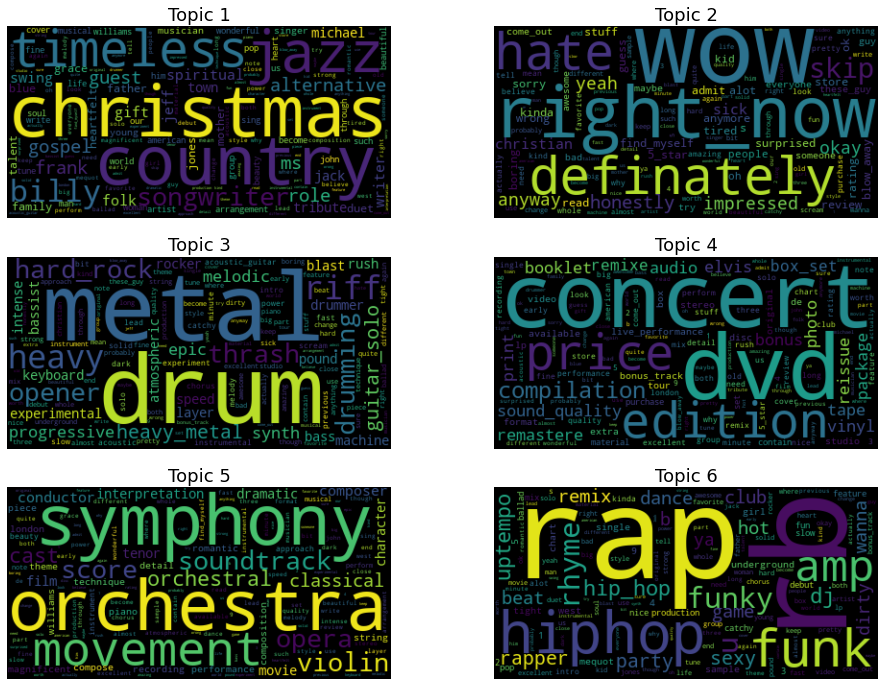

In [40]:
# Portions of the below code were borrowed from:
#***************************************************************
# *     Author: Jansen, S
# *     Date: 2020
# *     Title: Topic Modeling: Latent Dirichlet Allocation with
# *     sklearn
# *     Availability: https://github.com/PacktPublishing/Machin
# *     e-Learning-for-Algorithmic-Trading-Second-Edition/blob/
# *     master/15_topic_modeling/04_lda_with_sklearn.ipynb
#***************************************************************

pw = WordCloud()
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16, 12))
axes = axes.flatten()
for t, (topic, freq) in enumerate(pos_freqs.items()):
    pw.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(pw, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

#### Topic descriptions

- Topic 1 does not seem to be very coherent, as it has combined Christmas music, country, jazz and gospel into one category.
- Topic 2 is also ambiguous, and seems to be more focused on expression or emotion than any genre of music ("wow," "hate," "honestly," "impressed").
- Topic 3 is centered around rock and heavy metal.
- Topic 4 seems largely focused on descriptions of either the product or the type of performance featured in the product being reviewed(i.e. DVD, edition, concert, compilation, reissue).
- Topic 5 is centered around classical music and opera. 
- Topic 6 is centered around hip hop, funk and R&B.

#### Top 10 most relevant terms per topic

In [35]:
pos_relevant_words['index'] = pos_relevant_words.groupby('Topic')\
                                            ['Term'].cumcount()
pos_relevant_words.pivot_table(index='index', columns='Topic',
                                values='Term', aggfunc=''.join)

Topic,1,2,3,4,5,6
index,,,,,,
0,christmas,wow,metal,concert,orchestra,rap
1,country,right_now,drum,dvd,symphony,rb
2,jazz,definately,heavy,edition,movement,hiphop
3,timeless,hate,riff,price,soundtrack,funk
4,billy,skip,hard_rock,compilation,opera,amp
5,songwriter,honestly,opener,sound_quality,score,funky
6,alternative,impressed,drumming,remastere,violin,u
7,ms,yeah,thrash,elvis,orchestral,rhyme
8,gospel,anyway,heavy_metal,reissue,cast,hip_hop


### Visualization of positive topics

In [11]:
LDAvis_pos_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.030604 -0.031199       1        1  31.282034
3     -0.031035  0.060901       2        1  19.362679
4      0.032484 -0.107201       3        1  17.609055
1      0.022155  0.205877       4        1  13.032079
5      0.208681 -0.067823       5        1   9.555454
2     -0.262889 -0.060555       6        1   9.158702, topic_info=            Term          Freq         Total Category  logprob  loglift
182         disc   9871.000000   9871.000000  Default  30.0000  30.0000
137    recording  11441.000000  11441.000000  Default  29.0000  29.0000
360         beat   8172.000000   8172.000000  Default  28.0000  28.0000
448       single  10023.000000  10023.000000  Default  27.0000  27.0000
383  performance   7446.000000   7446.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
349          boy   1510.023682   3431.111816   Topic6  -5.1103   1.5697
202          big   1614.833618   7882.100586   Topic6  -5.0432   0.8051
514       catchy   1518.594238   4694.764160   Topic6  -5.1047   1.2618
587          top   1494.198364   5268.603027   Topic6  -5.1209   1.1303
69          roll   1493.291260   3489.169922   Topic6  -5.1215   1.5418

[359 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
305       2  0.059988      1
305       4  0.353316      1
305       5  0.046054      1
305       6  0.540366      1
117       2  0.159329      2
...     ...       ...    ...
944       6  0.148085   yeah
259       1  0.844856  young
259       2  0.017215  young
259       4  0.002087  young
259       6  0.135636  young

[919 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 2, 6, 3])

### Negative topic analysis

In [36]:
### The below .apply()...x.nlargest() line was borrowed from
#***************************************************************
# *     Title: Stack Overflow: Pandas dataframe : Group by A,
# *            take nlargest by B, output C
# *     Author: MaxU (username)
# *     Date: 2017
# *     Availability: https://stackoverflow.com/questions/43762\
# *     744/pandas-dataframe-group-by-a-take-nlargest-by-b-outp\
# *     ut-c
#***************************************************************

neg_rel_words = LDAvis_neg_prepared[2].reset_index()\
                    .groupby('Topic')['Term', 'Freq']\
                    .apply(lambda x: x.nlargest(10,'Freq'))\
                    .reset_index().drop(['level_1', 'Freq'],
                    axis=1)

neg_freqs = LDAvis_neg_prepared[2].pivot(index='Term',
                columns='Topic', values='Freq').fillna(0.0)
neg_freqs.columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4',
                   'Topic 5', 'Topic 6']

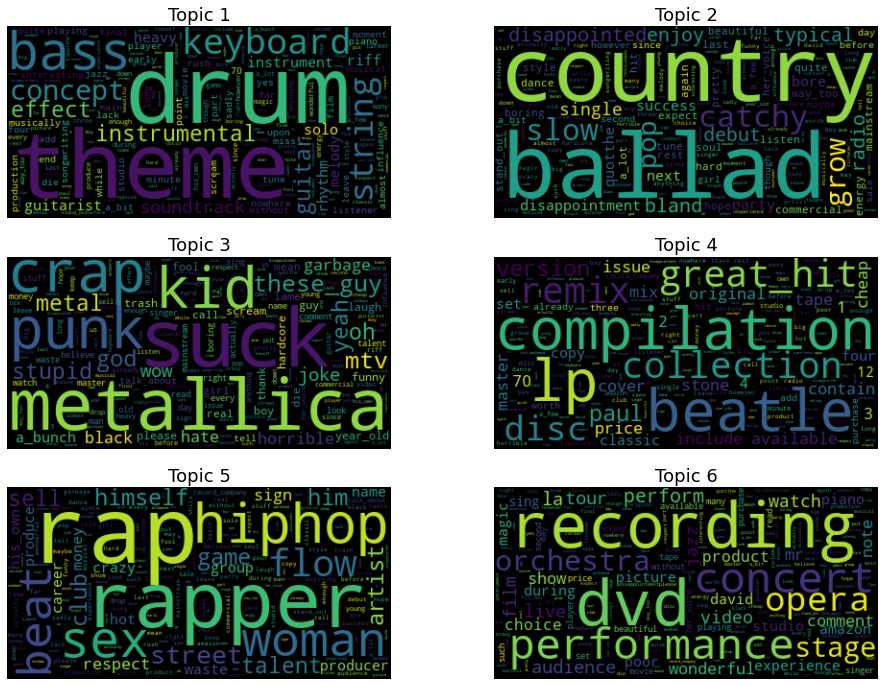

In [39]:
# Portions of the below code were borrowed from:
#***************************************************************
# *     Author: Jansen, S
# *     Date: 2020
# *     Title: Topic Modeling: Latent Dirichlet Allocation with
# *     sklearn
# *     Availability: https://github.com/PacktPublishing/Machin
# *     e-Learning-for-Algorithmic-Trading-Second-Edition/blob/
# *     master/15_topic_modeling/04_lda_with_sklearn.ipynb
#***************************************************************

nw = WordCloud()
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16, 12))
axes = axes.flatten()
for t, (topic, freq) in enumerate(neg_freqs.items()):
    nw.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(nw, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Topic descriptions

With a few exceptions, many of these topics do not contain many highly relevant terms that are explicitly negative. The topics also are somewhat similar to the positive topics.
- Topic 1 is centered around isntrumental aspects of music.
- Topic 2 is centered around country music.
- Topic 3 is focused on rock, and has the most overtly negative set of terms (i.e. "crap," "suck," "stupid.", "joke," "garbage").
- Topic 4 seems largely focused on descriptions of either the product or the type of performance featured in the product being sold, with many of these reviews clearly being about the Beatles.
- Topic 5 is centered around hip hop, funk and R&B.
- Topic 6 is focused on classical music and opera. 

#### Top 10 most relevant terms per topic

In [42]:
neg_rel_words['index'] = neg_rel_words.groupby('Topic')['Term']\
                                                    .cumcount()
neg_rel_words.pivot_table(index='index', columns='Topic',
                                values='Term', aggfunc=''.join)    

Topic,1,2,3,4,5,6
index,,,,,,
0,drum,country,suck,compilation,rap,dvd
1,theme,ballad,metallica,beatle,rapper,recording
2,bass,catchy,crap,lp,hiphop,performance
3,keyboard,slow,punk,great_hit,sex,concert
4,string,grow,kid,collection,woman,opera
5,concept,pop,these_guy,remix,beat,orchestra
6,instrumental,disappointed,mtv,disc,flow,stage
7,effect,bland,god,version,street,perform
8,guitar,radio,stupid,paul,himself,tour


### Vizualization of negative topics

In [12]:
LDAvis_neg_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.010335 -0.020084       1        1  23.859167
1     -0.085146 -0.063722       2        1  19.394075
2      0.137036  0.021179       3        1  15.173208
0     -0.079730  0.144369       4        1  14.396182
3      0.120515 -0.018514       5        1  13.796865
5     -0.082341 -0.063228       6        1  13.380507, topic_info=          Term         Freq        Total Category  logprob  loglift
160  recording   841.000000   841.000000  Default  30.0000  30.0000
139       live  1032.000000  1032.000000  Default  29.0000  29.0000
20     version   960.000000   960.000000  Default  28.0000  28.0000
191      metal   639.000000   639.000000  Default  27.0000  27.0000
151   original   937.000000   937.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
20     version   172.543411   960.236145   Topic6  -5.0937   0.2948
436      enjoy   128.764755   512.550598   Topic6  -5.3863   0.6300
338    without   132.465408   603.334961   Topic6  -5.3580   0.4952
19     through   132.858109   644.277832   Topic6  -5.3550   0.4325
79         old   125.471977   895.856262   Topic6  -5.4122   0.0457

[315 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
23        1  0.074942      1
23        2  0.010706      1
23        3  0.034795      1
23        4  0.778866      1
23        5  0.061560      1
...     ...       ...    ...
339       2  0.108695  young
339       3  0.158384  young
339       4  0.021739  young
339       5  0.447202  young
339       6  0.149067  young

[1560 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 1, 4, 6])

# Sentiment Analyis

In [44]:
### convert train/test normalized reviews into X_train/X_test datasets
X_train = pd.DataFrame(train_reviews_norm)
X_test = pd.DataFrame(test_reviews_norm)

### Establish baseline model

Logistic regression using a BOW-vectorized set of features (using unigrams) was used as a baseline model. Because precision-recall AUC is useful for evaluating predictions when classes are imbalanced (only 9.3% of reviews in the dataset are negative), scikit learn's average precision score was used as the primary evaluation metric. Scikit learn defines this metric as "the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight." ("Precision-Recall, n.d.)

In [19]:
## vectorize
cv = CountVectorizer(min_df=.01, max_df=.2)
cv_train = cv.fit_transform(X_train[0].values)
cv_test = cv.transform(X_test[0].values)
## fit model
baseline = LogisticRegression(penalty='l2', max_iter=1000)
baseline.fit(cv_train, y_train)
base_probs = baseline.predict_proba(cv_test)[:,1]
print('Baseline average precision score:',
      np.round(average_precision_score(y_test, base_probs),3))

Baseline average precision score: 0.54


### Addressing class imbalance

To limit overfitting on the dominant class (positive reviews) in this imbalanced dataset, negative reviews were upsampled (excluding the baseline model). To test the extent to which upsampling could improve performance, logistic regression models were run (similar to above) with a variety different upsampling factors applied to the minority class. A factor of 8 was eventually chosen, resulting in a modified training dataset in which 45% of reviews are negative.

In [8]:
X_y_train = X_train.copy(deep=True)
X_y_train['sentiment'] = y_train

### separate by class
X_y_train_pos = X_y_train[X_y_train.sentiment==0]
X_y_train_neg = X_y_train[X_y_train.sentiment==1]

### upsample minority, negative class by factor of 8
upsamp_neg = resample(X_y_train_neg, replace=True,
                      random_state=42,
                      n_samples=8*len(X_y_train_neg))

### combined positive with upsampled negative
X_train_upsamp = X_y_train_pos.append(upsamp_neg)

y_train_upsamp = X_train_upsamp['sentiment']
X_train_upsamp.drop('sentiment', axis=1, inplace=True)

print('Pct. negative reviews in upsampled dataset:',
      np.round(y_train_upsamp.mean(),2))

Pct. negative reviews in upsampled dataset: 0.45


### Vectorizing features
To determine how different approaches to feature vectorization would affect performance, a logistic regression model (using L2 regularization) was used to evaluate the following for both a bag-of-words model and a TF-IDF model:
- Unigrams vs. bigrams.
- Minimum document term frequency.
- Maximum document term frequency.

Each dataset (the combinations of the above features produced 48 datasets) was passed into the GridSearchLoop function (defined in the next section). Models aside from Logistic Regression were excluded from the loop during this process. While the overall difference between TF-IDF and BOW models was negligible, the following settings were consistently associated with better performance in both models:
- Use of bigrams.
- A max_df value of .2.
- A min_df value of 0.01.

The below section of code was used to generate 48 datasets built from various hyperparameters for initial testing, but was not used in final modeling.

In [87]:
%%time
start = time.time()
ngrams =  [('unigrams', (1,1)),
           ('bigrams', (1,2))]
max_dfs =  [.1, .15, .2]
min_dfs = [.01, .015, .02, .025]
vectorizers = ['BOW', 'TF-IDF']
vec_feature_sets = {}

for vec_name in vectorizers:
    for (gram_label, gram) in ngrams:
        for mx in max_dfs:
            for mn in min_dfs:
                if vec_name=='BOW':
                    vec = CountVectorizer(ngram_range=gram, min_df=mn, max_df=mx)
                else:
                    vec = TfidfVectorizer(ngram_range=gram, min_df=mn, max_df=mx)
                set_label = '_'.join([vec_name, gram_label, str(mx), str(mn)])
                X_train_trf = vec.fit_transform(X_train_upsamp[0].values)
                X_test_trf = vec.transform(X_test[0].values)
                vec_feature_sets[set_label] = {'train': None, 'test': None}
                vec_feature_sets[set_label]['train'] = X_train_trf
                vec_feature_sets[set_label]['test'] = X_test_trf
                print('Finished building', set_label)
                print('Time lapsed:', time.time() - start)

The below code, simplified from above, was used to generate the final two BOW and TF-IDF feature sets based on the optimal hyperparameters discovered from the process described above. These datasets were pre-built so that they would not have to be repeatedly generated during the cross-validation process used later for testing different classification models.

In [9]:
# %%time
vectorizers = ['BOW', 'TF-IDF']
vec_feature_sets = {}

for vec_name in vectorizers:
    if vec_name=='BOW':
        vec = CountVectorizer(ngram_range=(1,2), min_df=.01, max_df=.2)
    else:
        vec = TfidfVectorizer(ngram_range=(1,2), min_df=.01, max_df=.2)
    X_train_trf = vec.fit_transform(X_train_upsamp[0].values)
    X_test_trf = vec.transform(X_test[0].values)
    vec_feature_sets[vec_name] = {'train': None, 'test': None}
    vec_feature_sets[vec_name]['train'] = X_train_trf
    vec_feature_sets[vec_name]['test'] = X_test_trf

### Model evaluation and hyperparameter tuning

To experiment with different approaches to predicting sentiment, five different classification models were used:
- Logistic Regression with L2 regularization.
- Stochastic Gradient Descent using log loss (admittedly similar to the above approach). For regularization, L1, L2 and elastic net were tested.
- Stochastic Gradient Descent using a hinge loss function.
- Support Vector Classifier (testing both hinge loss and squared hinge loss functions).
- Naive Bayes.

In [121]:
### build empty df to store results from hyperparameter tuning
sentiment_results = pd.DataFrame(columns=['classifier', 'vectorizer',
                    'cv_score', 'train_score', 'test_score', 'params'])

In [122]:
### Portions of this code starting with "for (name, classifier).."
### lere borrowed from:
#***************************************************************
# *     Author: Shanahan, J
# *     Date: 2020
# *     Title: Unit-09-Pipelines-and-end-to-end-ML-Project
# *     Availability: https://github.iu.edu/jshanah/I526_AML_FA2
# *     0/blob/master/Assignments/Unit-09-Pipelines-and-end-to-e
# *     nd-ML-Project/HW09_End_to_end_Machine_Learning_Project.i
# *     pynb
#***************************************************************

def GridSearchLoop(vec_type, X_tr, y_tr, X_tst, y_tst, i=0, prefix='',
                   n_jobs=-1, verbose=1):
    
    '''This function, given a datset (via X_tr and y_tr) uses grid
    search to perform hyperparameter tuning for five different models.
    It then makes predictions for each model. The results from each
    model are written into the sentiment_results dataframe'''

    # Create a list of classifiers
    classifiers = [
        ('Logistic Regression - L2 Norm', LogisticRegression(random_state=42)),
        ('Stochastic GD - log loss', SGDClassifier(random_state=42)),
        ('Stochastic GD - hinge loss', SGDClassifier(random_state=42)),        
        ('Linear SVC - hinge', LinearSVC(random_state=42)),
        ('Naive Bayes', MultinomialNB())
    ]

    # Specify params for each classifier.
    params_grid = {
        'Logistic Regression - L2 Norm': {
            'penalty': ['l2'],
            'tol': (0.0001, 0.00001, 0.000001), 
            'C': (0.001, 0.01, 0.1, 1),
            'class_weight': ['balanced'],
            'max_iter': [1000]
        },

        'Stochastic GD - log loss': {
            'loss': ['log'],
            'n_iter_no_change': [10],
            'penalty': ('l2', 'l1', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.000001), 
            'alpha': (0.0001, 0.001, 0.01, 0.1),
            'class_weight': ['balanced'] 
        },

        'Stochastic GD - hinge loss': {
            'loss': ['hinge'],
            'n_iter_no_change': [10],
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.000001), 
            'alpha': (0.0001, 0.001, 0.01, 0.1),
            'class_weight': ['balanced'] 
        },
        
        'Linear SVC - hinge' : {
                'loss': ('hinge', 'squared_hinge'),
               'penalty': ['l2'],
                'tol': (0.0001, 0.00001, 0.000001), 
                'C': (0.001, 0.01, 0.1, 1),
                'class_weight': ['balanced'],
                'max_iter': [1000]
        },
        
        'Naive Bayes': {
            'alpha': (0.0001, 0.001, 0.1, 1.0),
        }
    }
    
    for (name, classifier) in classifiers:

        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        pipe = Pipeline([
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(pipe, params, scoring='average_precision',
                                   cv=5, n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_tr, y_tr)
        
        if 'hinge' in name or 'Linear SVC' in name:
            calibrator = CalibratedClassifierCV(grid_search, cv='prefit')
            model=calibrator.fit(X_tr, y_tr)
            
            train_preds = model.predict_proba(X_tr)[:,1]
            train_score = average_precision_score(y_tr, train_preds)

            # Predict on test set
            test_preds = model.predict_proba(X_tst)[:,1]
            test_score = average_precision_score(y_tst, test_preds)
        else:
            train_preds = grid_search.predict_proba(X_tr)[:,1]
            train_score = average_precision_score(y_tr, train_preds)

            # Predict on test set
            test_preds = grid_search.predict_proba(X_tst)[:,1]
            test_score = average_precision_score(y_tst, test_preds)
        
        # Collect best parameters found by grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()

        ### get cross validated score of best model
        cv_score = grid_search.best_score_
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")

        # Record results
        sentiment_results.loc[len(sentiment_results)] = [prefix+name] + [vec_type,
                        cv_score, train_score, test_score, json.dumps(param_dump)]

In [142]:
### This loops through the pre-build BOW and TF-IDF features sets
### and passes each dataset into the above GridSearchLoop function.
start = time.time()
last = start
iter = 1
vec_feature_set_labels = vec_feature_sets.keys()
for vec_str in vec_feature_set_labels:
    vec_X_train = vec_feature_sets[vec_str]['train']
    vec_X_test = vec_feature_sets[vec_str]['test']
    print(vec_str)
    GridSearchLoop(vec_str, vec_X_train, y_train_upsamp, vec_X_test,
                      y_test, i=0, prefix='', n_jobs=-1, verbose=12)
    update = time.time()
    ### keep track of progress
    print('Finished iter: {}; time for iter: {}; total time lapsed: {}'\
          .format(iter, update - last, update - start))
    last = update
    iter+=1

From the hyperparameter tuning process, performance was consistently higher across all models that used TF-IDF-weighted features. Therefore, BOW-vectorized features were excluded when fitting final models.

As an aside, the large dropoff between performance on held out folds during cross-validation and predicting on the test set was expected because the negative reviews are oversampled and thus, significantly overrepresented in the training data.

In [139]:
sentiment_results.drop('params', axis=1)\
    .sort_values(by='test_score', ascending=False)

,classifier,vectorizer,cv_score,train_score,test_score
5,Logistic Regression - L2 Norm,TF-IDF,0.946328,0.952174,0.692017
8,Linear SVC - hinge,TF-IDF,0.946382,0.952296,0.689896
7,Stochastic GD - hinge loss,TF-IDF,0.941518,0.945185,0.686882
6,Stochastic GD - log loss,TF-IDF,0.936497,0.939618,0.680970
9,Naive Bayes,TF-IDF,0.915671,0.917272,0.643193
1,Stochastic GD - log loss,BOW,0.940207,0.949258,0.638220
0,Logistic Regression - L2 Norm,BOW,0.939951,0.949381,0.633847
3,Linear SVC - hinge,BOW,0.939381,0.949312,0.631508
2,Stochastic GD - hinge loss,BOW,0.936153,0.943361,0.623815
4,Naive Bayes,BOW,0.888550,0.890122,0.534222


In [125]:
### write results locally so that models don't need to be re-run each time.
sentiment_results.to_csv(path + 'sentiment_results.csv', index=False)

In [141]:
### Retreive the best parameters to input into final models
for mod in sentiment_results[sentiment_results.vectorizer=='TF-IDF'].classifier:
    best_params = sentiment_results[sentiment_results.classifier==mod].params
    best_params = re.sub(r'\[|\]|\"|predictor__', '', best_params.values[0])
    print(mod, '\nBest parameters:', best_params, '\n')

Logistic Regression - L2 Norm 
Best parameters: C, 0.1, class_weight, balanced, max_iter, 1000, penalty, l2, tol, 0.0001 

Stochastic GD - log loss 
Best parameters: alpha, 0.0001, class_weight, balanced, loss, log, n_iter_no_change, 10, penalty, elasticnet, tol, 1e-05 

Stochastic GD - hinge loss 
Best parameters: alpha, 0.001, class_weight, balanced, loss, hinge, n_iter_no_change, 10, penalty, l2, tol, 0.0001 

Linear SVC - hinge 
Best parameters: C, 0.01, class_weight, balanced, loss, squared_hinge, max_iter, 1000, penalty, l2, tol, 0.0001 

Naive Bayes 
Best parameters: alpha, 0.0001 



### Run final models with chosen hyperparameters
The models were then refitted with the above parameters on the full training data and then used to generate predictions for the test data. The results were then scored based on average precision (weighted by recall) and the F-measure.

In [127]:
### The method for obtaining the otpimal decision threshold
### using the f-score was recommended by:
#***************************************************************
# *     Author: Brownlee, J
# *     Date: 2020
# *     Title: A Gentle Introduction to Threshold-Moving for
# *            Imbalanced Classification
# *     Availability: https://machinelearningmastery.com/thresho
# *     ld-moving-for-imbalanced-classification/
#***************************************************************

def fit_and_score_model(model):
    
    '''Fits a initialized model passed into the function and returns
    predicted classes, an average precision score, accuracy, an
    F-measure, and precision and recall scores at all possible
    decision thresholds. The decision threshold for determining
    classes is based off of the maximum F-measure found across
    all precision/recall combinations.'''

    model.fit(vec_feature_sets['TF-IDF']['train'], y_train_upsamp)
    probs = model.predict_proba(vec_feature_sets['TF-IDF']['test'])[:,1]
    ### use precision/recall values across full precision recall curve
    ### to generate corresponding f scores used to find optimal
    ### decision threshold
    pr, recall, thresh = precision_recall_curve(y_test, probs)
    opt_thresh = thresh[np.argmax((2 * pr * recall) / (pr + recall))]
    ### create classes using the optimal threshold
    preds = np.where(probs >= opt_thresh, 1, 0)
    avg_prec = np.round(average_precision_score(y_test, probs), 3)
    f_score = np.round(f1_score(y_test, preds), 3)
    accuracy = np.round(accuracy_score(y_test, preds),3)

    return preds, avg_prec, pr, recall, preds, f_score, accuracy 

The below code fits and scores each of the five models.

In [128]:
### Logistic Regression
log = LogisticRegression(penalty='l2', max_iter=1000, tol=.0001,
                         class_weight='balanced', random_state=42)
log_preds, log_avg_prec, log_pr, log_recall, log_preds, log_f_score,\
log_accuracy = fit_and_score_model(log)

## SGD with log loss
sgd_log = SGDClassifier(penalty='l2', loss='log', max_iter=1000,
                        alpha=.0001, n_iter_no_change=10,tol=.0001,
                        class_weight='balanced', random_state=42)
sgd_log_preds, sgd_log_avg_prec, sgd_log_pr, sgd_log_recall, sgd_log_preds,\
sgd_log_f_score, sgd_log_accuracy = fit_and_score_model(sgd_log)

## SGD with hinge loss
sgd_hinge = SGDClassifier(penalty='elasticnet', loss='hinge',
                          max_iter=1000,n_iter_no_change=10, alpha=.0001, tol=.0001,
                          class_weight='balanced', random_state=42)

### need to use calibratedclassifer to produce probabilities for hinge
###loss since predict_proba not available for hinge
sgd_hinge.fit(vec_feature_sets['TF-IDF']['train'], y_train_upsamp)
sgd_calibrator = CalibratedClassifierCV(sgd_hinge, cv='prefit')
sgd_hinge_mod = sgd_calibrator.fit(vec_feature_sets['TF-IDF']['train'],
                                   y_train_upsamp)
sgd_hin_preds, sgd_hin_avg_prec, sgd_hin_pr, sgd_hin_recall, sgd_hin_preds,\
sgd_hin_f_score, sgd_hin_accuracy = fit_and_score_model(sgd_hinge_mod)

### SVC
svc = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=1000, C=0.1,
                tol=.00001, class_weight='balanced', random_state=42)

### need to use calibratedclassifer to produce probabilities for hinge
### loss since predict_proba not available for hinge
svc.fit(vec_feature_sets['TF-IDF']['train'], y_train_upsamp)
svc_calibrator = CalibratedClassifierCV(svc, cv='prefit')
svc_mod = svc_calibrator.fit(vec_feature_sets['TF-IDF']['train'],
                             y_train_upsamp)
svc_preds, svc_avg_prec, svc_pr, svc_recall, svc_preds, svc_f_score,\
svc_accuracy = fit_and_score_model(svc_mod)

### Naive Bayes
nb = MultinomialNB(alpha=.0001)
nb_preds, nb_avg_prec, nb_pr, nb_recall, nb_preds,\
nb_f_score, nb_accuracy = fit_and_score_model(nb)

### Sentiment Analysis Results

Although the differences between the top two (and perhaps the top three) models are negligible, the logistic regression model produced the highest F-measure and average precision score among the five models tested. Coincidentally, it also produced the highest accuracy (which was not a primary metric of interest). Naive Bayes, which appeared to suffer from overfitting on the over-sampled training dataset, had the lowest performance when making predictions on the test set.

In [129]:
mods = ['Logistic Regression', 'SGD - log loss', 'SGD - hinge loss',
        'Support Vector Classifier', 'Naive Bayes']
f1_scores = [log_f_score, sgd_log_f_score, sgd_hin_f_score,
             svc_f_score, nb_f_score]
avg_prec_scores = [log_avg_prec, sgd_log_avg_prec, sgd_hin_avg_prec,
                   svc_avg_prec, nb_avg_prec]
accuracy_scores = [log_accuracy, sgd_log_accuracy, sgd_hin_accuracy,
                   svc_accuracy, nb_accuracy]
results_matrix = pd.DataFrame(columns=['Models', 'F-measure',
                                'Avg. Precision', 'Accuracy'])
results_matrix.Models = mods
results_matrix['Avg. Precision'] = avg_prec_scores
results_matrix['F-measure'] = f1_scores
results_matrix['Accuracy'] = accuracy_scores
results_matrix.sort_values(by='F-measure', ascending=False)

,Models,F-measure,Avg. Precision,Accuracy
0,Logistic Regression,0.639,0.692,0.938
3,Support Vector Classifier,0.638,0.690,0.936
2,SGD - hinge loss,0.636,0.687,0.932
1,SGD - log loss,0.626,0.681,0.935
4,Naive Bayes,0.594,0.643,0.930


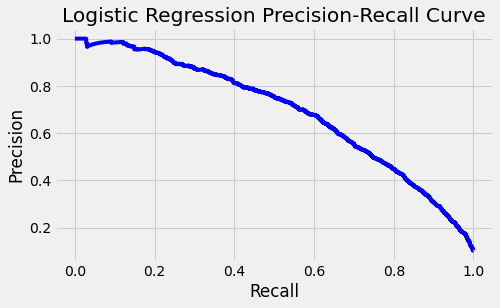

In [130]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,4))
plt.plot(log_recall, log_pr, color='blue')
plt.title('Logistic Regression Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### Logistic Regression Model Summary

In [131]:
print('Classification Report\n\n', classification_report(y_test, log_preds))

print('Model confusion matrix')
print(confusion_matrix(y_test, log_preds))

print('\nOverall model accuracy',
      np.round(accuracy_score(y_test, log_preds),3))

Classification Report

               precision    recall  f1-score   support

           0       0.96      0.97      0.97     18194
           1       0.67      0.61      0.64      1806

    accuracy                           0.94     20000
   macro avg       0.82      0.79      0.80     20000
weighted avg       0.94      0.94      0.94     20000

Model confusion matrix
[[17661   533]
 [  708  1098]]

Overall model accuracy 0.938


#### Stochastic Gradient Descent (Log Loss) Model Summary

In [132]:
print('Classification Report\n\n', classification_report(y_test, sgd_log_preds))

print('Model confusion matrix')
print(confusion_matrix(y_test, sgd_log_preds))

print('\nOverall model accuracy',
      np.round(accuracy_score(y_test, sgd_log_preds),3))

Classification Report

               precision    recall  f1-score   support

           0       0.96      0.97      0.96     18194
           1       0.65      0.60      0.63      1806

    accuracy                           0.93     20000
   macro avg       0.81      0.79      0.80     20000
weighted avg       0.93      0.93      0.93     20000

Model confusion matrix
[[17608   586]
 [  717  1089]]

Overall model accuracy 0.935


#### Stochastic Gradient Descent (Hinge Loss) Model Summary

In [133]:
print('Classification Report\n\n', classification_report(y_test, sgd_hin_preds))

print('Model confusion matrix')
print(confusion_matrix(y_test, sgd_hin_preds))

print('\nOverall model accuracy',
      np.round(accuracy_score(y_test, sgd_hin_preds),3))

Classification Report

               precision    recall  f1-score   support

           0       0.97      0.96      0.96     18194
           1       0.62      0.65      0.64      1806

    accuracy                           0.93     20000
   macro avg       0.79      0.81      0.80     20000
weighted avg       0.93      0.93      0.93     20000

Model confusion matrix
[[17468   726]
 [  625  1181]]

Overall model accuracy 0.932


#### Support Vector Classifier (Squared Hinge Loss) Model Summary

In [134]:
print('Classification Report\n\n', classification_report(y_test, svc_preds))

print('Model confusion matrix')
print(confusion_matrix(y_test, svc_preds))

print('\nOverall model accuracy',
      np.round(accuracy_score(y_test, svc_preds),3))

Classification Report

               precision    recall  f1-score   support

           0       0.96      0.97      0.96     18194
           1       0.65      0.63      0.64      1806

    accuracy                           0.94     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.93      0.94      0.94     20000

Model confusion matrix
[[17577   617]
 [  670  1136]]

Overall model accuracy 0.936


#### Naive Bayes Model Summary

In [135]:
print('Classification Report\n\n', classification_report(y_test, nb_preds))

print('Model confusion matrix')
print(confusion_matrix(y_test, nb_preds))

print('\nOverall model accuracy',
      np.round(accuracy_score(y_test, nb_preds),3))

Classification Report

               precision    recall  f1-score   support

           0       0.96      0.97      0.96     18194
           1       0.63      0.57      0.59      1806

    accuracy                           0.93     20000
   macro avg       0.79      0.77      0.78     20000
weighted avg       0.93      0.93      0.93     20000

Model confusion matrix
[[17581   613]
 [  783  1023]]

Overall model accuracy 0.93


# Conclusion

In the topic analysis, the final set of topics (six each for both positive and negative reviews) were largely intuitive to understand, though both sets each featured one category that seemed more of a miscellaneous collection than than a cohesive grouping. One of the positive topics did include some overtly positive terms among its most relevant words, and the same was true for overtly negative terms in one of the negative topics. That said, when it came to subject material, there appeared to be more similarities than conflicts when between the positive and negative review topic groupings. Overall, the coherence scores for both topic models, (roughly 0.4 and 0.49 for positive and negative topics, respectively), were an improvement over initial baseline models.

In the sentiment analysis, the final best-performing Logistic Regression model had an F-measure score of .64 and a recall-weighted average precision score of .69, a significant improvement over the baseline model, which had an average precision of .54. Several additional steps added to the baseline model, such as using TF-IDF-weighted vectors instead of a BOW model, using bigrams instead of unigrams, and upsampling the training data to include a significantly larger number of negative reviews all helped improve performance. That said, the final model was still significantly better at predicting positive reviews than negative ones, with precision and recall of .96 and .97, respectively (as opposed to .61 and .67 for negative reviews). In terms of potential improvements to the current approach, experimenting with different types of document vectorization, such as using a pre-trained model like [GloVe](https://nlp.stanford.edu/projects/glove/), could add further nuance not provided by the TF-IDF-weighted features. Different classification modeling approaches such as using a neural network or gradient boosting might also produce better results.

## References

Brownlee, J. (2020). A gentle introduction to threshold-moving for imbalanced classification. *Machine Learning Mastery.* https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

Jansen, S. (2020). Topic Modeling: Latent Dirichlet Allocation with sklearn. [GitHub repository]. Retrieved from:
https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/15_topic_modeling/04_lda_with_sklearn.ipynb

Kapadia, S. (2019). Evaluate Topic Models: Latent Dirichlet Allocation (LDA). *Towards Data Science.* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

MaxU (anonymous user name). (2017, May 3). Pandas dataframe : Group by A, take nlargest by B, output C. [Stack Overflow]. Retrieved from
https://stackoverflow.com/questions/43762744/pandas-dataframe-group-by-a-take-nlargest-by-b-output-c

McAuley, J. (n.d.) Amazon Product data. Retrieved from: http://jmcauley.ucsd.edu/data/amazon/

NLTK Corpora (n.d.) *NLTK Project.* Retrieved from https://www.nltk.org/nltk_data/

Precision-Recall (n.d.) *Scikit-learn.* Retrieved from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

Sarkar, D. (2018). Contractions.py. [GitHub repository]. Retrieved from: https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch07_Analyzing_Movie_Reviews_Sentiment/contractions.py

Shanahan, J. (2020). Unit-09-Pipelines-and-end-to-end-ML [Source code from Indiana University I-526 course].  Retrieved from: https://github.iu.edu/jshanah/I526_AML_FA20/blob/master/Assignments/Unit-09-Pipelines-and-end-to-end-ML-Project/HW09_End_to_end_Machine_Learning_Project.ipynb